In [1]:
from YOLOtrack11 import YOLOtrack11
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL.ImageFile
import ultralytics.engine.results as results
import PIL
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from importlib import reload
# from ultralytics.utils.metrics import box_iou
from scipy.optimize import linear_sum_assignment
import torch
from ultralytics.utils import ops

def plot_gt(path,ax):
    data=np.loadtxt(path.replace("images", "labels").replace("jpg","txt").replace("tif","txt")).T
    # print(data)
    cls = data[0]
    bboxes = data[1:-1].T
    z = data[-1]
    # print(bboxes)
    
    return plot_result(ax,path, cls,bboxes,z)


def plot_result(ax,path,cls,bboxes,z):
    img = np.array(PIL.Image.open(path))
    ax.imshow(img,cmap="grey",vmin=1.95e4,vmax=2.05e4)
    ax.axis("off")
    for bbox,z_value in zip(bboxes,z):
        x,y,w,h = bbox*512
        rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="yellow", facecolor='none')
        tx,ty = rect.get_xy()
        tx+=6
        ty-=12
        ax.text(tx,ty,f"z={z_value:.3f}",fontsize="small",bbox=dict(facecolor='white', alpha=0.5,))
        ax.add_patch(rect)
    return bboxes,z

      
def match_predictions(pred_bboxes, gt_bboxes, pred_classes, true_classes,threshold):

        iou = box_iou(torch.Tensor(gt_bboxes), torch.Tensor(pred_bboxes))

        correct = np.zeros((pred_classes.shape[0])).astype(bool)
        gt_pred_matches = np.zeros((true_classes.shape[0],pred_classes.shape[0] ), dtype=bool)
        # LxD matrix where L - labels (rows), D - detections (columns)
        correct_class = true_classes[:, None] == pred_classes
        iou = iou * correct_class  # zero out the wrong classes
        iou = iou.cpu().numpy()

        cost_matrix = iou * (iou >= threshold)
        if cost_matrix.any():
            labels_idx, detections_idx = linear_sum_assignment(cost_matrix, maximize=True)
            valid = cost_matrix[labels_idx, detections_idx] > 0
            if valid.any():
                correct[detections_idx[valid]] = True
                gt_pred_matches[labels_idx,detections_idx] = valid

        return correct, gt_pred_matches
def box_iou(box1, box2, eps=1e-7):

    (a1, a2), (b1, b2) = box1.float().unsqueeze(1).chunk(2, 2), box2.float().unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

In [2]:
# reload(results)
model = YOLOtrack11("../ultralytics/runs/zaxis/train163/weights/last.pt")
# print(model.model.model)
print("loaded")
dataset_path = "../ultralytics/data_gen/Dataset_hard/images/test"
test_images = os.listdir(dataset_path)
random_image = lambda: dataset_path+"/"+test_images[np.random.randint(0,len(test_images))]



loaded


(512, 512)

0: 512x512 2.6ms
Speed: 1.9ms preprocess, 2.6ms inference, 59.8ms postprocess per image at shape (1, 3, 512, 512)
gt  : [   0.080408     0.11934     0.19528     0.05552     0.92278    0.093172     0.85067      0.3963     0.16401     0.38354     0.23293     0.78749     0.25144     0.34588     0.31461     0.75622     0.79324      0.3829     0.28271     0.85833     0.75239     0.25335      0.6739     0.69432     0.76516     0.71027
     0.70772     0.46075     0.94767     0.75175     0.56669     0.50989     0.48819]
yolo: [   0.079261     0.11602     0.19585    0.042856     0.92084    0.087724     0.85081     0.39747     0.17397      0.3882     0.23648     0.78936     0.24799     0.34706     0.31128     0.75756     0.79289     0.38392     0.28058      0.8635     0.75601     0.24325     0.67508     0.69927     0.77006     0.70499
     0.70701      0.4664     0.94985     0.73948     0.56272     0.50827     0.49338]
gt undetected: []


/tmp/ipykernel_2372379/4141739295.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  iou = iou * correct_class  # zero out the wrong classes


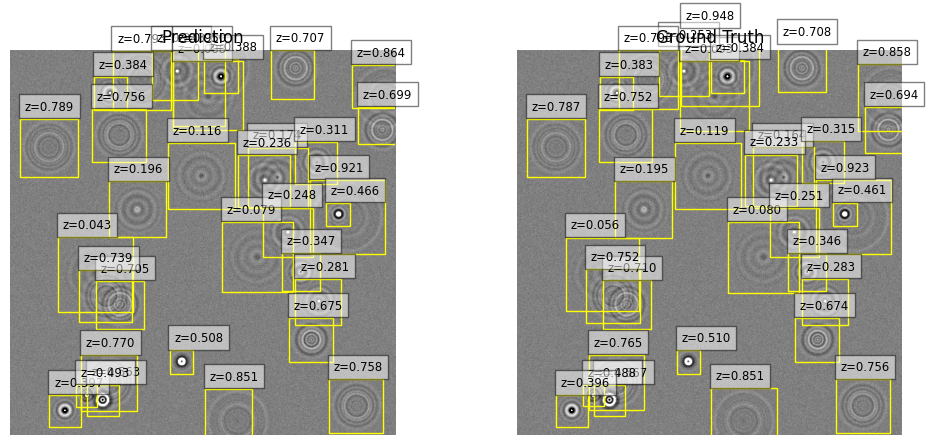

In [3]:

plt.figure(figsize=(12,5))
image = random_image()
img = np.array(PIL.Image.open(image))#-12768
print(img.shape)
results = model.predict(img)
res = results[0].zaxis.data.cpu().numpy()
plt.subplot(1,2,1)
plt.title("Prediction")
plot_result(plt.gca(),image,res[:,4],ops.xyxy2xywh(res[:,:4])/512,res[:,6])
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Ground Truth")
# ops.scale_boxes((512,512), gt_bbox, ori_shape, ratio_pad=ratio_pad)  # native-space labels
gt_bboxes,gt_z_values = plot_gt(image,plt.gca())
true_bboxes = ops.xywh2xyxy(gt_bboxes) * np.array((512,512))[[1, 0, 1, 0]]  # target boxes
_, gt_pred_matcher = match_predictions(res[:,:4],true_bboxes,np.zeros(len(res)),np.zeros(len(true_bboxes)),0.5)
print("gt  :", gt_z_values[np.where(gt_pred_matcher.T)[1]])
print("yolo:", res[:,-1])
# print("corr:", np.array(corr))
print("gt undetected:", gt_z_values[np.where(gt_pred_matcher.sum(1)==0)[0]])



/tmp/ipykernel_1279566/38466707.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  iou = iou * correct_class  # zero out the wrong classes


<Figure size 2000x700 with 0 Axes>

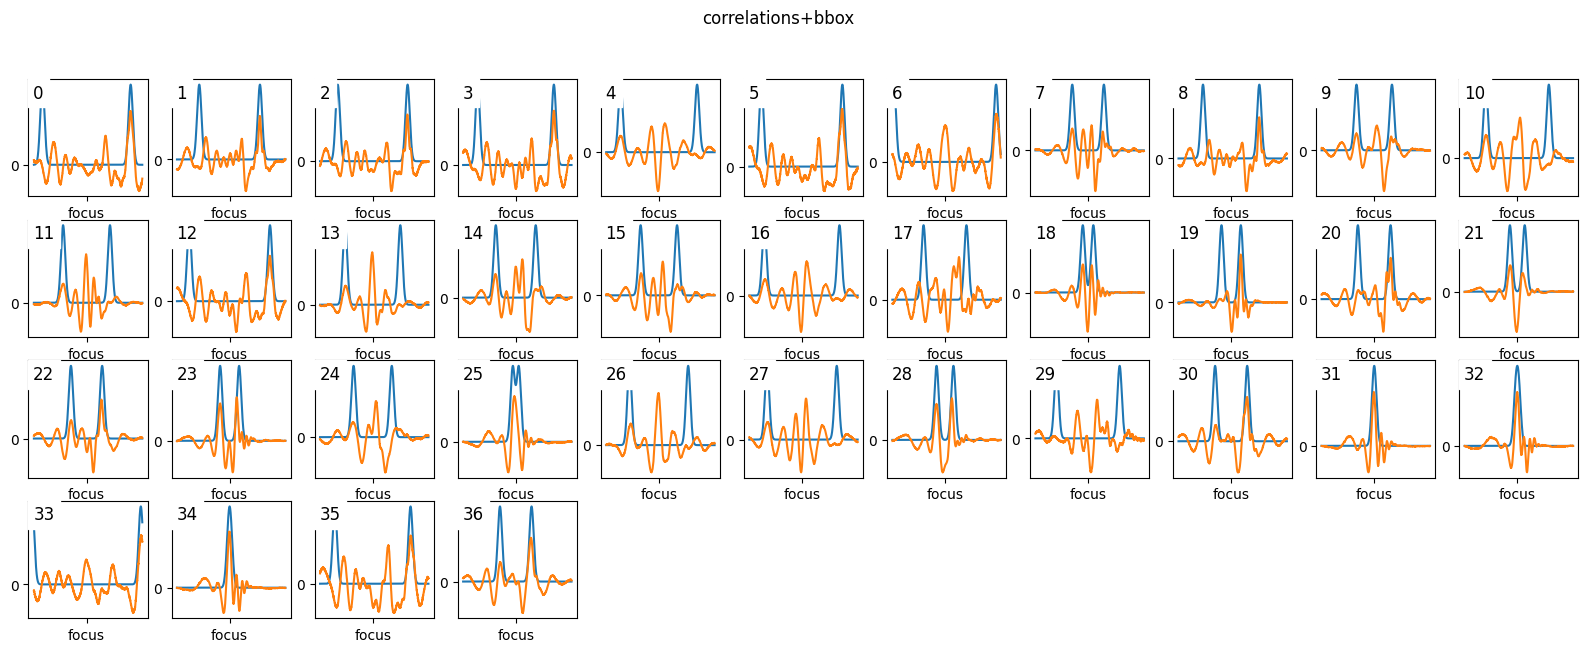

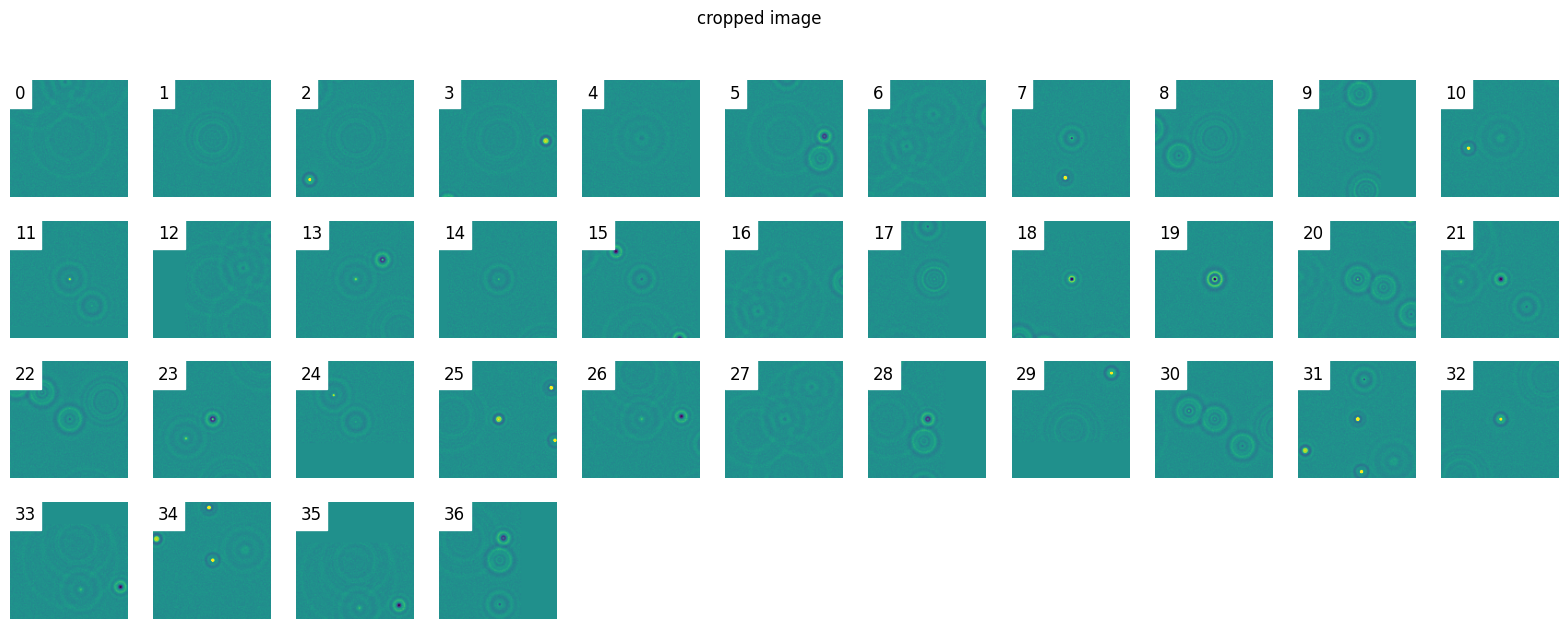

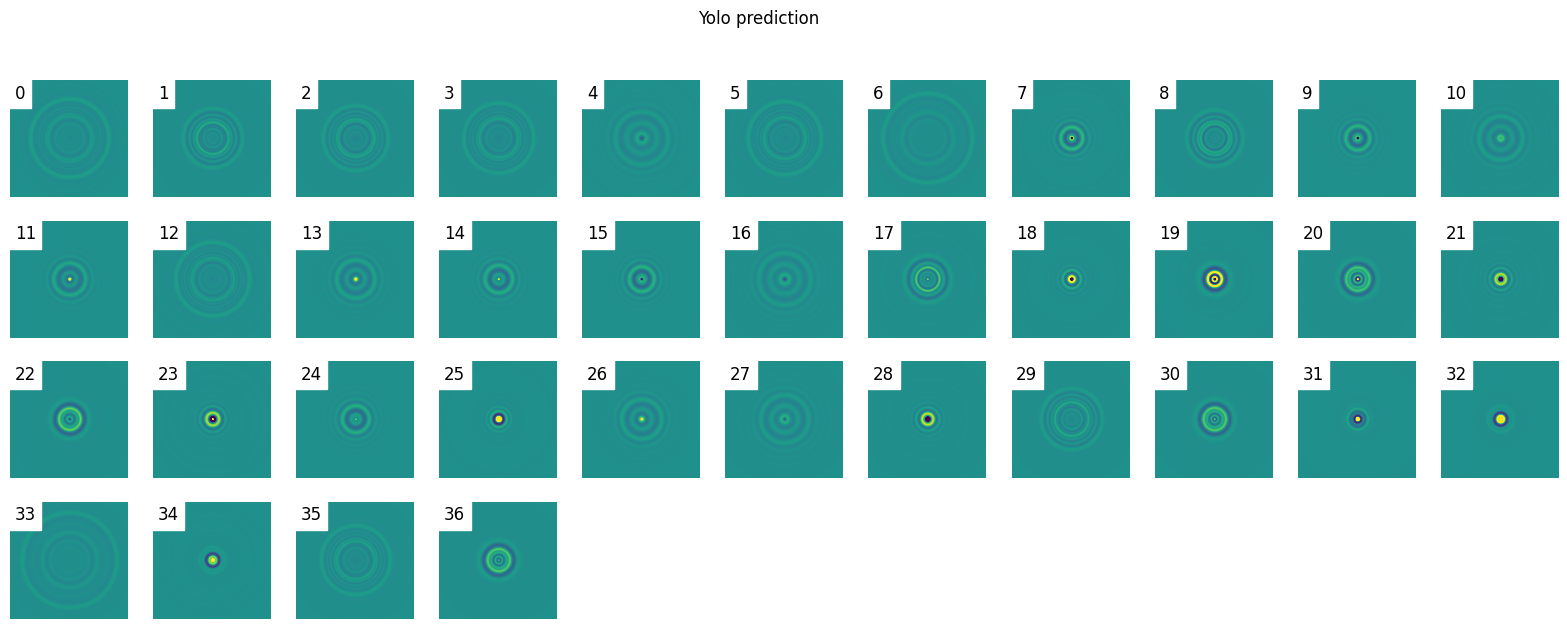

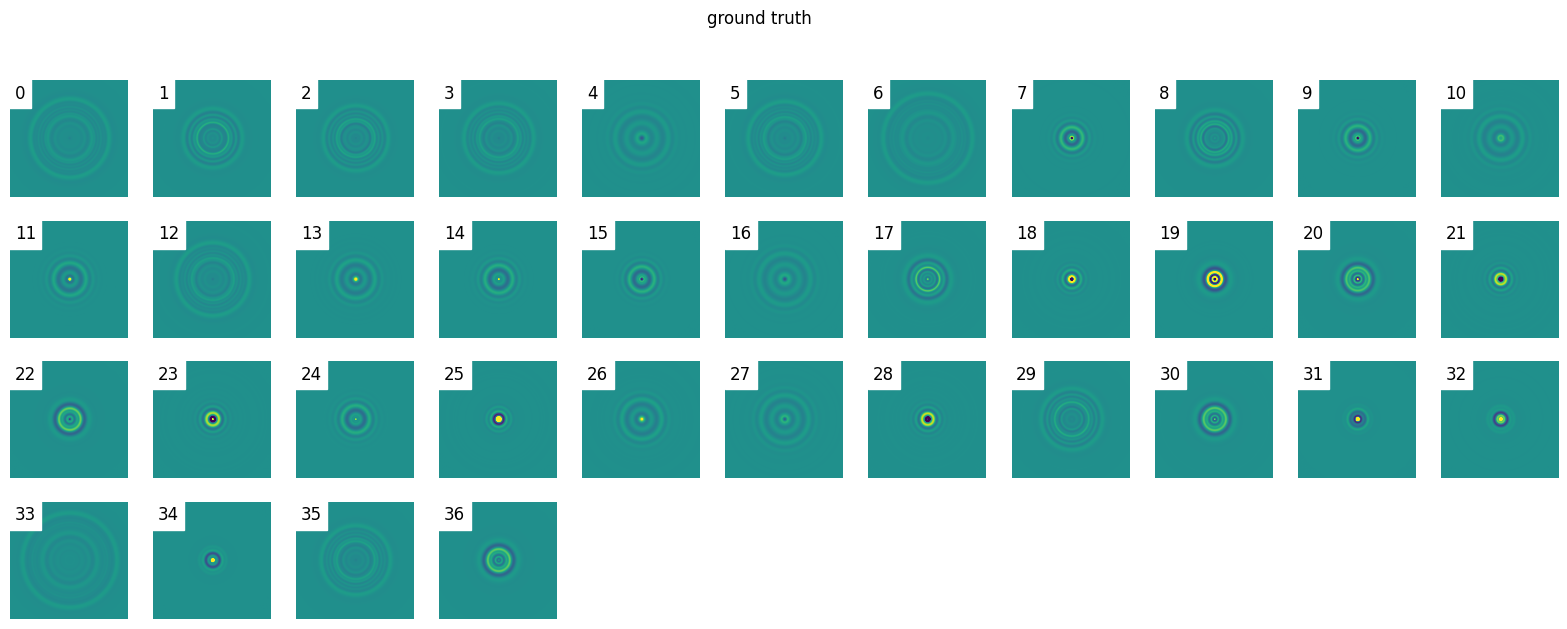

In [43]:
# plt.figure()
# plt.imshow(results[0].orig_img)
# plt.figure(figsize=(20,2))

padding=128
size=128
padded_image = np.pad(results[0].orig_img,padding,mode="constant",constant_values=2e4)

# plt.axis("off")
captures = np.empty((len(res),size,size))
for i,box in enumerate(res):
    # print(box)
    x1,y1,x2,y2,_,_,z = box
    w,h = x2-x1,y2-y1
    if(x1 == 0):
        x1-=h-w
        w = h
    if(y1 == 0):
        y1-=w-h
        h = w
    if(x2 == 511):
        x2+=h-w
        w = h
    if(y2 == 511):
        y2+=w-h
        h = w
    x,y = 0.5*(x1+x2),0.5*(y1+y2)
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    captures[i] = padded_image[y+padding-size//2:y+padding+size//2,x+padding-size//2:x+padding+size//2]
# captures/=
# captures-=1
downsampled_reference = (np.load("data_gen/ripples_downsampled.npy")/10000)-2
true_bboxes = ops.xywh2xyxy(gt_bboxes) * np.array((512,512))[[1, 0, 1, 0]]  # target boxes
# ops.scale_boxes((512,512), gt_bbox, ori_shape, ratio_pad=ratio_pad)  # native-space labels
_, gt_pred_matcher = match_predictions(res[:,:4],true_bboxes,np.zeros(len(res)),np.zeros(len(true_bboxes)),0.5)
plt.figure(figsize=(20,2*len(captures)//11+1))
plt.figure(figsize=(20,2*len(captures)//11+1))
plt.figure(figsize=(20,2*len(captures)//11+1))
plt.figure(figsize=(20,2*len(captures)//11+1))
plt.figure(figsize=(20,2*len(captures)//11+1))
def bells(x,w,*args):
    f = np.sum([np.exp(-(w*(x-mu)**2)) for mu in args],axis=0)
    return f/np.max(f)
x = np.arange(len(downsampled_reference))
corr = []
for i,capture in enumerate(captures):

    x1,y1,x2,y2,_,_,pred_z = res[i]
    w,h = x2-x1,y2-y1
    v = (max(w,h)*(2)-55)
    z  = (-v/0.21)+761,(v/0.21)+761
    plt.figure(1)
    plt.suptitle("correlations+bbox")
    correlation = np.pow((downsampled_reference*(capture/10000-2)).sum(axis=(1,2)),1)
    plt.subplot(len(captures)//11+1,11,i+1)
    plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")
    plt.plot(bells(x,5e-4,*z)*(np.max(correlation)-np.min(correlation)))
    plt.plot(correlation)
    # plt.axvline(pred_z*len(downsampled_reference), c="red")
    plt.xticks([761],["focus"])
    plt.yticks([0])
    # plt.ylim(0,0.5)c
    # plt.tight_layout()

    plt.figure(2)
    plt.suptitle("cropped image")
    plt.subplot(len(captures)//11+1,11,i+1)
    plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")
    plt.imshow(capture,vmin=1.85e4,vmax=2.15e4)
    plt.axis("off")
    # plt.tight_layout()
    plt.figure(3)
    plt.subplot(len(captures)//11+1,11,i+1)
    plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")
    plt.suptitle("Yolo prediction")
    plt.imshow(downsampled_reference[np.round(pred_z*len(downsampled_reference)).astype(int)],vmin=-0.05,vmax=0.05)
    plt.axis("off")

    plt.figure(4)
    plt.suptitle("ground truth")
    plt.subplot(len(captures)//11+1,11,i+1)
    plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")

    correct_detection = np.where(gt_pred_matcher.T[i])[0]
    # if correct_detection:
    gt_image = (downsampled_reference[np.round(gt_z_values[correct_detection]*len(downsampled_reference)).astype(int)])
    # else:
    #     gt_image = np.zeros((1,128,128))
    plt.imshow(gt_image[0],vmin=-0.05,vmax=0.05)
    plt.axis("off")
    # plt.figure(4)
    # plt.suptitle("image via max correlations+bbox size")

    # plt.subplot(len(captures)//11+1,11,i+1)
    # plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")
    # plt.imshow(downsampled_reference[np.argmax(correlation*bells(x,5e-4,*z))],vmin=-0.05,vmax=0.05)
    # corr.append(np.argmax(correlation*bells(x,5e-4,*z))/len(downsampled_reference))
    # plt.axis("off")



    # plt.colorbar()



In [13]:
undetected = downsampled_reference[np.round(gt_z_values[np.where(gt_pred_matcher.sum(1)==0)[0]]).astype(int)]
plt.figure(figsize=(20,2))
for i,img in enumerate(undetected):
    plt.subplot(1,11,i+1)
    plt.imshow(img)
plt.show()

<Figure size 2000x200 with 0 Axes>